In [5]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [6]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

In [7]:
# System Parameters
#m = 0.5 # mass
l = 0.2 # distance from rotor to COM
#I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

# Noise for measurements:
v = [0.01, 0.001, 0.2, 0.2]

In [8]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nominal trajectory, measurements

In [48]:
class PlanarDrone:
    def __init__(self):
        self.v = [0.01, 0.001, 0.2, 0.2]

    def control(self, X, t):
        theta, thetadot, x, xdot, z, zdot, m = X

        # desired trajectory
        theta_des, x_des, z_des = desired_trajectory(t)

        # error
        x_err = x_des - x
        z_err = z_des - z

        # control
        tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
        F = (F_k_z*z_err - F_k_zdot*zdot)

        return F, tau

    def f(self, X, t, U='closedloop'):
        theta, thetadot, x, xdot, z, zdot, m = X
        I = 2/5*m*l**2

        # control
        if type(U) == str:
          if U == 'closedloop':
            F, tau = self.control(X, t)
            U = np.vstack((F, tau))
        else:
            F = np.interp(t, self.tsim, U[0,:])
            tau = np.interp(t, self.tsim, U[1,:])

        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*g)/m

        d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot, 0]

        return d_x

    def h(self, x, v):
        theta, thetadot, x, xdot, z, zdot, m = x

        y = np.array([theta, thetadot, x, z])

        return y

    def simulate(self, x0, tsim, U='closedloop'):
        self.tsim = tsim
        result = odeint(self.f, x0, tsim, args=(U,))
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, Y, U

In [24]:
sys = PlanarDrone()

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]
x0 = np.hstack((x0, 0.5))
tsim = np.arange(0, 300, 0.1)

X, Y, U = sys.simulate(x0, tsim)

In [25]:
print(X.shape)
print(Y.shape)
print(U.shape)

(7, 3000)
(4, 3000)
(2, 3000)


In [26]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(tsim)

<Axes: xlabel='Time', ylabel='z'>

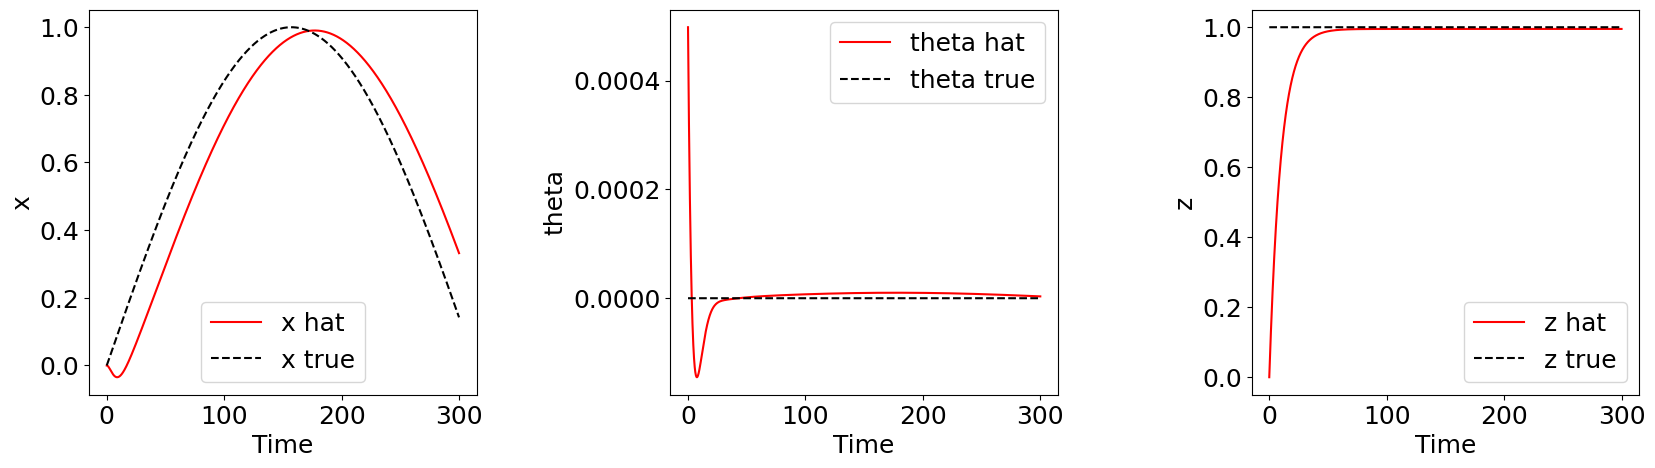

In [27]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, z_des, None, z, label_var='z', ax=ax3)

Add noise to measurements

In [28]:
v = np.array([0.01, 0.001, 0.2, 0.2])
noise = np.array( [np.random.normal(0, vi, Y.shape[1]) for vi in v] )

In [29]:
Ynoisy = Y + noise

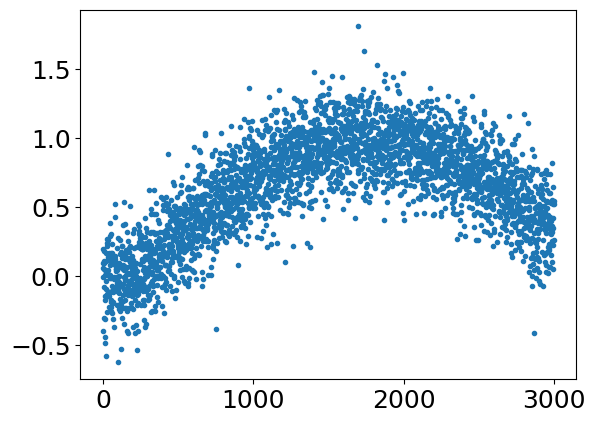

In [30]:
plt.plot(Ynoisy[2,:], '.')

# Initial conditions

In [31]:
# Initial conditions
x0 = np.atleast_2d(np.array([(np.random.random()-0.5)*1e-3 for i in range(6)])).T
x0 = np.vstack((x0, 0.01))
P0 = 1000000*np.eye(X.shape[0])

# Noise defined by measurement noise
R = np.diag(v**2)

# Fairly accurate model
Q = 5e-4*np.eye(X.shape[0])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays.

In [32]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [33]:
import ekf

In [34]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, z, zdot, m = np.ravel(X)
    I = 2/5*m*l**2
    F, tau = np.ravel(U)

    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = -F*np.sin(theta)/m
    new_z = z + zdot*dt
    new_zdot = (F*np.cos(theta)-m*g)/m

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_z, new_zdot, m])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, z, zdot, m = np.ravel(X)

    y = np.atleast_2d(np.array([theta, thetadot, x, z])).T

    return y

In [35]:
xhat, P, s = ekf.ekf(Ynoisy, x0, f_d, h_d, Q, R, U)

In [36]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
z_hat = xhat[4, :]
m_hat = xhat[6,:]

<Axes: xlabel='Time', ylabel='m'>

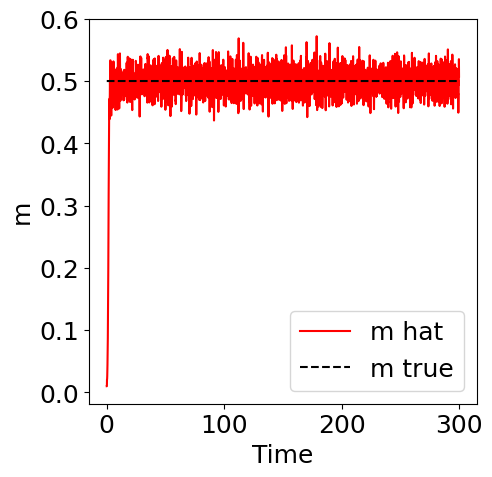

In [37]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, 0.5*np.ones_like(m_hat), None, m_hat, label_var='m', ax=ax1)

<Axes: xlabel='Time', ylabel='z'>

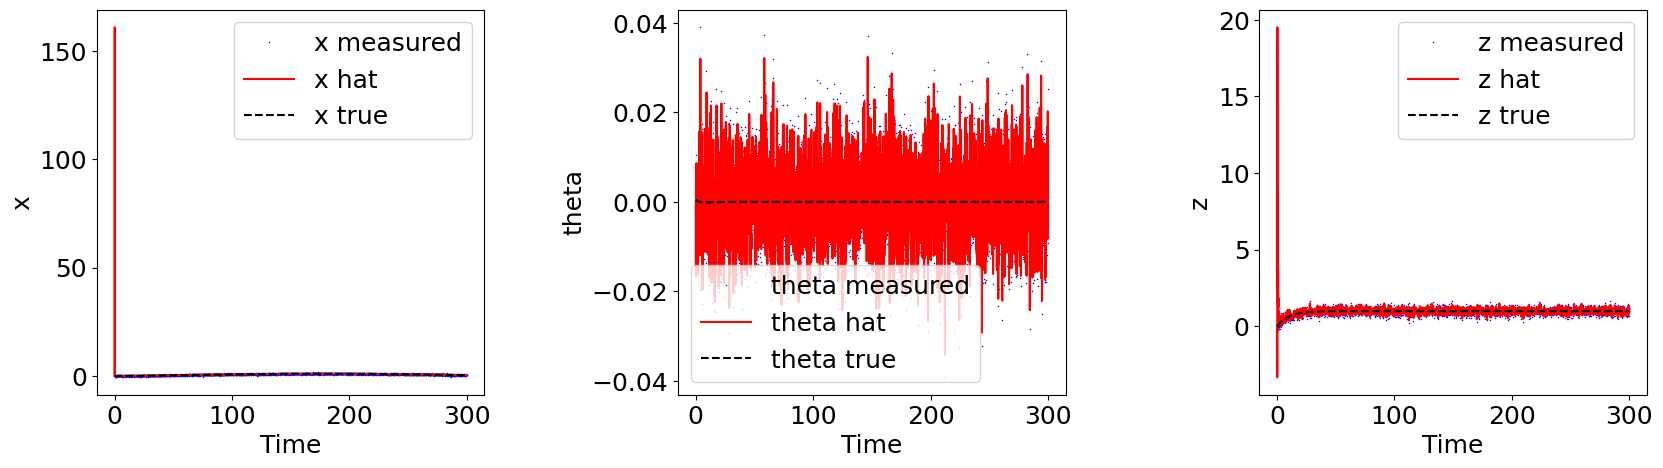

In [38]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x, Ynoisy[2,:], x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, z, Ynoisy[3,:], z_hat, label_var='z', ax=ax3)

In [39]:
# Empirical observability

In [40]:
def empirical_observability_matrix(system, x0, tsim, eps=1e-4):
    """ Empirically calculates the observability matrix O for a given system & input.

        Inputs
            system:             simulator object
            x0:                 initial state
            tsim:               simulation time
            usim:               simulation inputs
            eps:                amount to perturb initial state

        Outputs
            O:                  numerically calculated observability matrix
            X                   nominal trajectory simulation data
            deltay:             the difference in perturbed measurements at each time step
                                (basically O stored in a 3D array)
    """

    # Simulate once for nominal trajectory
    X, Y, U = system.simulate(x0, tsim, U='closedloop')
    n_state = X.shape[0]  # number of states
    n_output = Y.shape[0]  # number of outputs

    # Calculate O
    w = len(tsim)  # of points in time window
    delta = eps * np.eye(n_state)  # perturbation amount for each state
    deltay = np.zeros((n_output, n_state, w))  # preallocate deltay
    for k in range(n_state):  # each state
        # Perturb initial condition in both directions
        x0plus = x0 + delta[:, k]
        x0minus = x0 - delta[:, k]

        # Simulate measurements from perturbed initial conditions
        _, yplus, _ = system.simulate(x0plus, tsim, U=U)
        _, yminus, _ = system.simulate(x0minus, tsim, U=U)

        # Calculate the numerical Jacobian & normalize by 2x the perturbation amount
        deltay[:, k, :] = np.array(yplus - yminus) / (2 * eps)

    # Construct O by stacking the 3rd dimension of deltay along the 1st dimension, O is a (p*m x n) matrix
    O = []  # list to store datat at each time point fo O
    for j in range(w):
        O.append(deltay[:, :, j])

    O = np.vstack(O)

    return O, X, deltay

In [43]:
tsim

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 2.997e+02, 2.998e+02,
       2.999e+02])

In [49]:
sys = PlanarDrone()

# Establish initial condition and simulation times
x0 = X[:,0]
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
O, X, deltay = empirical_observability_matrix(sys, x0, tsim, eps=1e-4)

# Analyze O
W = O.T@O
eig = np.linalg.eigvals(W)
CN = np.max(eig) / np.min(eig)
print('Condition Number = ', CN)
print('')
print('Observability Gramian:')
print(W)

Condition Number =  4559487381861.011

Observability Gramian:
[[ 5.05026270e+12  1.36666592e+14  9.88686530e+08 -1.32138779e+10
   3.81915444e+09  1.52139677e+08  3.75870122e+11]
 [ 1.36666592e+14  3.81380574e+15  2.90453972e+10 -3.46126868e+11
   1.07685204e+11  9.72195413e+09  4.45901437e+12]
 [ 9.88686530e+08  2.90453972e+10  2.42866133e+05 -2.36885473e+06
   8.37224028e+05  1.14528907e+05 -2.23417505e+07]
 [-1.32138779e+10 -3.46126868e+11 -2.36885473e+06  3.61789481e+07
  -9.60329774e+06  6.08804268e+05 -1.81793938e+09]
 [ 3.81915444e+09  1.07685204e+11  8.37224028e+05 -9.60329774e+06
   3.06742956e+06  7.80499710e+05 -2.39985137e+08]
 [ 1.52139677e+08  9.72195413e+09  1.14528907e+05  6.08804268e+05
   7.80499710e+05  3.32229219e+07 -2.50785434e+10]
 [ 3.75870122e+11  4.45901437e+12 -2.23417505e+07 -1.81793938e+09
  -2.39985137e+08 -2.50785434e+10  2.02029080e+13]]


In [50]:
np.diag(np.linalg.inv(W))

array([2.51348473e-10, 7.15569279e-13, 7.05165452e-04, 7.48364793e-06,
       6.27314456e-04, 1.59890584e-06, 1.58314240e-12])